In [280]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime

import scipy.stats as stats
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from scipy.stats import pearsonr



In [281]:
obs_path = f'NN_train_test_data.pkl'
RF_path = f'RF2.pkl'
NN_path = f'NN_optim.pkl'

In [282]:
class plotting():
    def __init__(self, NN_path, RF_path, observation_path, dpi=300):
        self.NN_path = NN_path
        self.RF_path = RF_path
        self.observation_path = observation_path
        self.read_data()

        # for plotting
        self.dpi=dpi
        self.RF_color = 'green'
        self.NN_color = '#069AF3'
        self.obs_color = 'tab:gray'

    def read_data(self):
        # get predictions
        with open(self.NN_path, 'rb') as file:
            NN_data = pickle.load(file)

        NN_test = NN_data['pred_NN_test']
        NN_train = NN_data['pred_NN_train']

        with open(self.observation_path, 'rb') as file:
            obs_data = pickle.load(file)

        no2_observation_train = obs_data['trainig_data']
        no2_observation_test = obs_data['test_data']
        time_train = obs_data['trainig_time']
        time_test = obs_data['testing_time']


        with open(self.RF_path, 'rb') as file:
            RF_data = pickle.load(file)
        
        RF_test = RF_data['y_test_pred']
        RF_train = RF_data['y_train_pred']

        self.NN_test = np.squeeze(NN_test)
        self.NN_train = np.squeeze(NN_train)
        self.RF_test = np.array(RF_test)
        self.RF_train = np.array(RF_train)
        self.no2_observation_train = np.array(no2_observation_train)
        self.no2_observation_test = np.array(no2_observation_test)
        self.time_train = (time_train * 10**9).astype('datetime64[ns]')
        self.time_test = (time_test * 10**9).astype('datetime64[ns]')
        return None
    
    def test_or_train(self, test):
        if test:
            y1 = self.NN_test
            y2 = self.RF_test
            obs = self.no2_observation_test
            t = self.time_test
            label = 'Test'
        else:
            y1 = self.NN_train
            y2 = self.RF_train
            obs = self.no2_observation_train
            t = self.time_train
            label = 'Train'
        
        return y1, y2, obs, t, label
    
    def plot_PDE(self, test=True, obs=False):
        # TODO: add obs data
        y_NN, y_RF, y_obs, t, label = self.test_or_train(test)

        kde_NN = stats.gaussian_kde(y_NN)
        kde_RF = stats.gaussian_kde(y_RF)

        xs_NN = np.linspace(min(y_NN) - 1, max(y_NN) + 1, len(y_NN))
        xs_RF = np.linspace(min(y_RF) - 1, max(y_RF) + 1, len(y_RF))

        pdf_NN = kde_NN(xs_NN)
        pdf_RF = kde_RF(xs_RF)

        fig, ax1 = plt.subplots(1, 1, dpi=self.dpi, figsize=(10, 5))
        ax1.plot(xs_NN, pdf_NN, label=f'NN', color=self.NN_color)
        ax1.plot(xs_RF, pdf_RF,label=f'RF', color=self.RF_color)

        if obs:
            kde_obs = stats.gaussian_kde(y_obs)
            xs_obs = np.linspace(min(y_obs) - 1, max(y_obs) + 1, len(y_obs))
            pdf_obs = kde_obs(xs_obs)
            ax1.plot(xs_obs, pdf_obs, label='Observation', color=self.obs_color, ls='--')
        
        ax1.legend()
        ax1.set_xlabel('O$_3$ concentration [$\mu$g /m$^3$]')
        ax1.set_ylabel('Probability Density')
        ax1.grid(True)

    def plot_scatter(self, test=True):
        fig, ax1 = plt.subplots(1, 1, dpi=self.dpi, figsize=(10, 5))
        y_NN, y_RF, y_obs, t, label = self.test_or_train(test)
        
        # Scatter plots
        size = 1
        transp = 0.4
        ax1.scatter(y_obs, y_NN, label='Train', color=self.NN_color, s=size, alpha=transp)
        ax1.scatter(y_obs, y_RF, label='Test', color=self.RF_color, s=size, alpha=transp)

        # 1:1 line
        line = np.array([0, np.max([np.max(y_NN), np.max(y_RF)])])
        ax1.plot(line, line, zorder=5, linestyle='dashed', color='black', label='1:1 line', alpha=.7)
        ax1.set_aspect('equal', 'box')

        ax1.set_xlabel(r'Measured [$\text{NO}_2$] ($\mu g/\text{m}^3$)')
        ax1.set_ylabel(r'Predicted [$\text{NO}_2$] ($\mu g/\text{m}^3$)')
        ax1.legend()
        ax1.grid()

    def plot_long_timeseries(self, test=True, all=True, start_month=1, start_day=1, n_months=3, n_days=0):
        y_NN, y_RF, y_obs, t, label = self.test_or_train(test)
        
        fig, ax1 = plt.subplots(dpi=self.dpi, figsize=(40, 4), sharey=True)

        ax1.plot(t, y_NN, alpha=.5, label='NN', color=self.NN_color)
        ax1.plot(t, y_RF, alpha=.5, label='RF', color=self.RF_color)
        ax1.plot(t, y_obs, alpha=.5, label='Observation', color=self.obs_color, ls='--')
        ax1.grid(True)
        ax1.set_xlabel('Date')
        ax1.set_ylabel(r'[$\text{NO}_2$] ($\mu g/\text{m}^3$)')
        ax1.legend(loc='upper right')

        if not all:
            if test:
                ax1.set_xlim(datetime.date(2018, start_month, start_day), datetime.date(2018, start_month + n_months, start_day + n_days))
            else:
                ax1.set_xlim(datetime.date(2017, start_month, start_day), datetime.date(2017, start_month + n_months, start_day + n_days))
        else:
            ax1.set_xlim(t[0], t[-1])

    def get_stats(self, RF=True):
        if RF:
            print('Stats for RF')
            y_train_pred = self.RF_train
            y_test_pred = self.RF_test
        else:
            print('Stats for NN')
            y_train_pred = self.NN_train
            y_test_pred = self.NN_test

        y_train = self.no2_observation_train
        y_test = self.no2_observation_test

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        correlation_train, _ = pearsonr(y_train, y_train_pred)
        correlation_test, _ = pearsonr(y_test, y_test_pred)

        explained_variance_train = explained_variance_score(y_train, y_train_pred)
        explained_variance_test = explained_variance_score(y_test, y_test_pred)

        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)

        print(f'RMSE train (𝜇𝑔/𝑚3): {rmse_train:.2f}')
        print(f'RMSE test (𝜇𝑔/𝑚3): {rmse_test:.2f}')
        print(f'Correlation train: {correlation_train:.2f}')
        print(f'Correlation test: {correlation_test:.2f}')
        print(f'Explained variance train: {explained_variance_train:.2f}')
        print(f'Explained variance test: {explained_variance_test:.2f}')
        print(f'MAE train (𝜇𝑔/𝑚3): {mae_train:.2f}')
        print(f'MAE test (𝜇𝑔/𝑚3): {mae_test:.2f}')

        return rmse_train, rmse_test, correlation_train, correlation_test, explained_variance_train, explained_variance_test, mae_train, mae_test
    


In [283]:
plot_obj = plotting(NN_path, RF_path, obs_path)

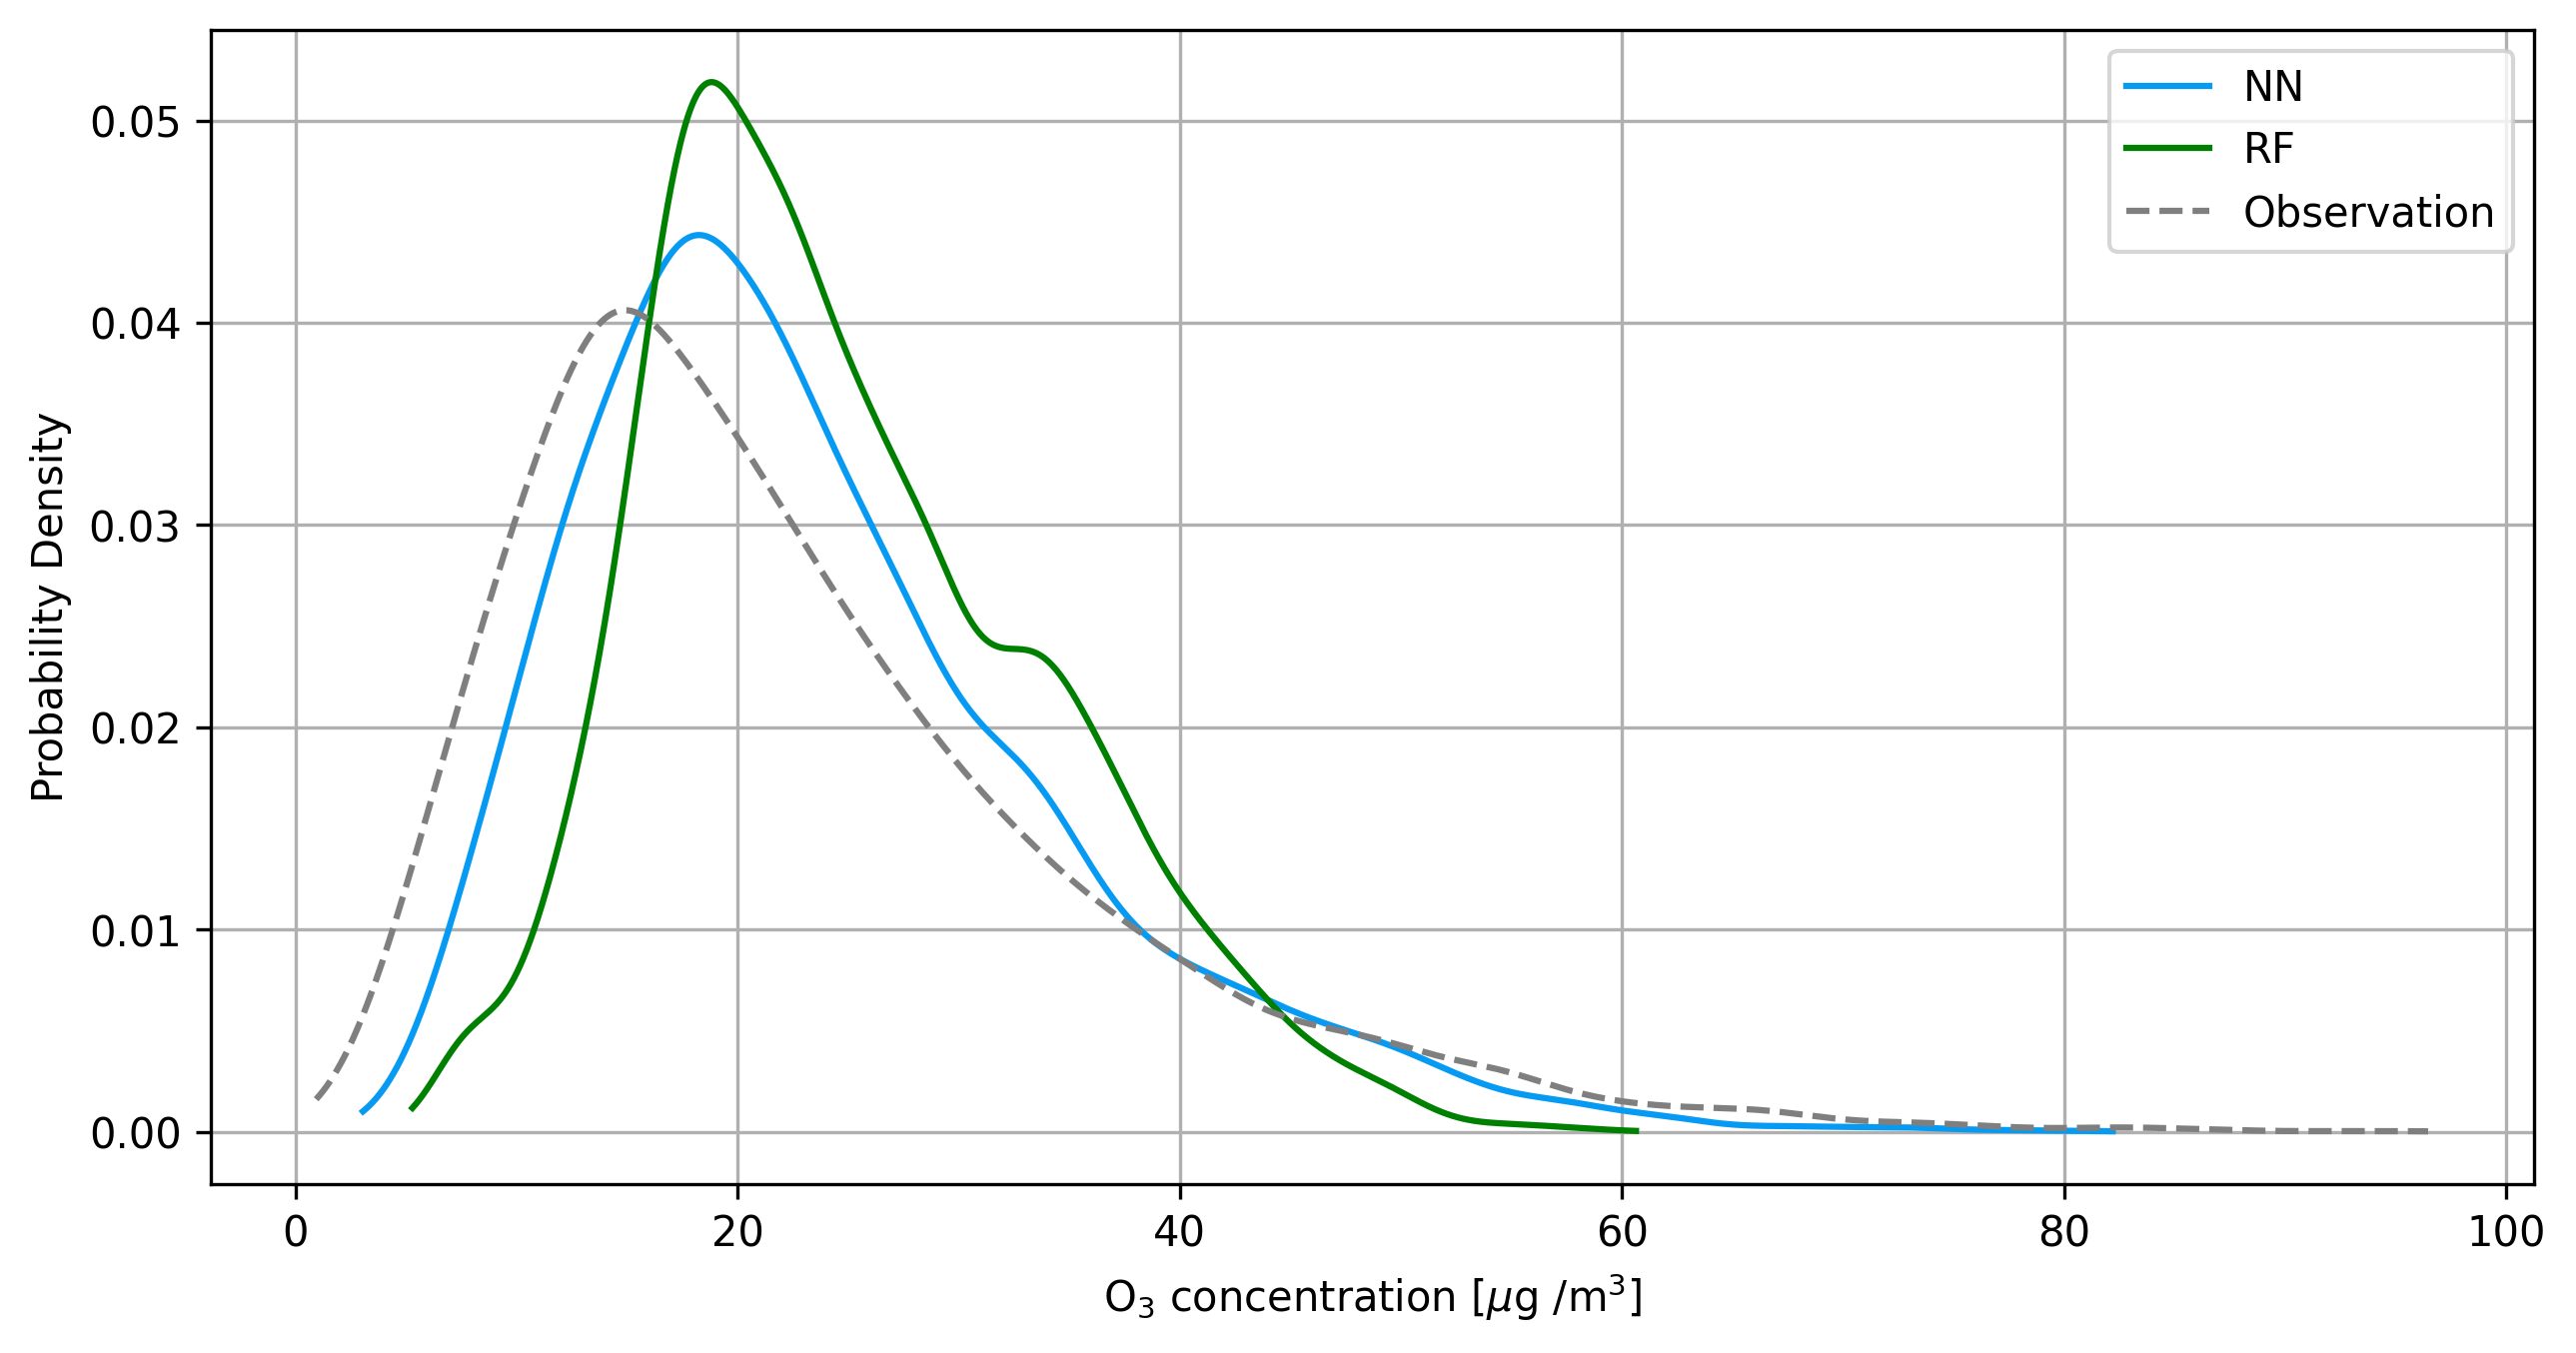

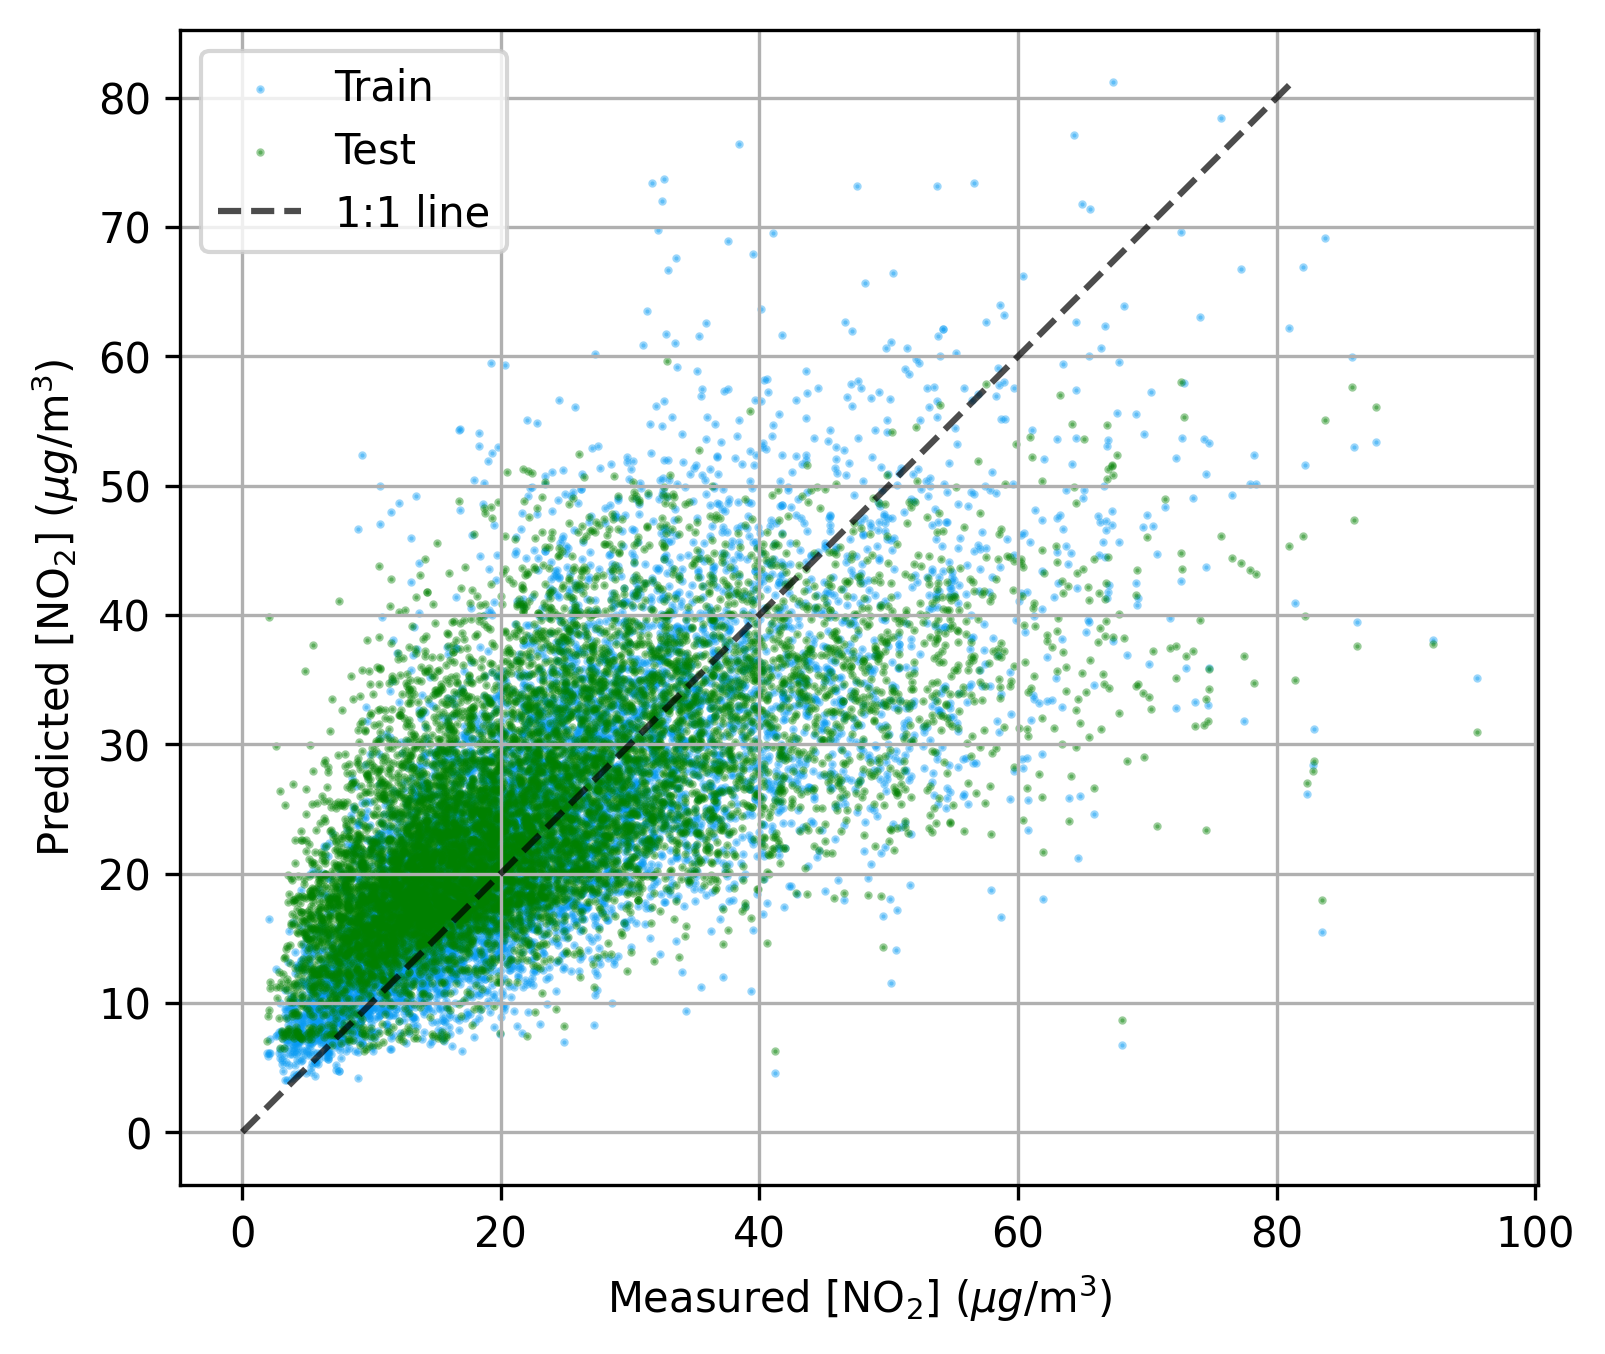

In [284]:
plot_obj.plot_PDE(obs=True)
plot_obj.plot_scatter()

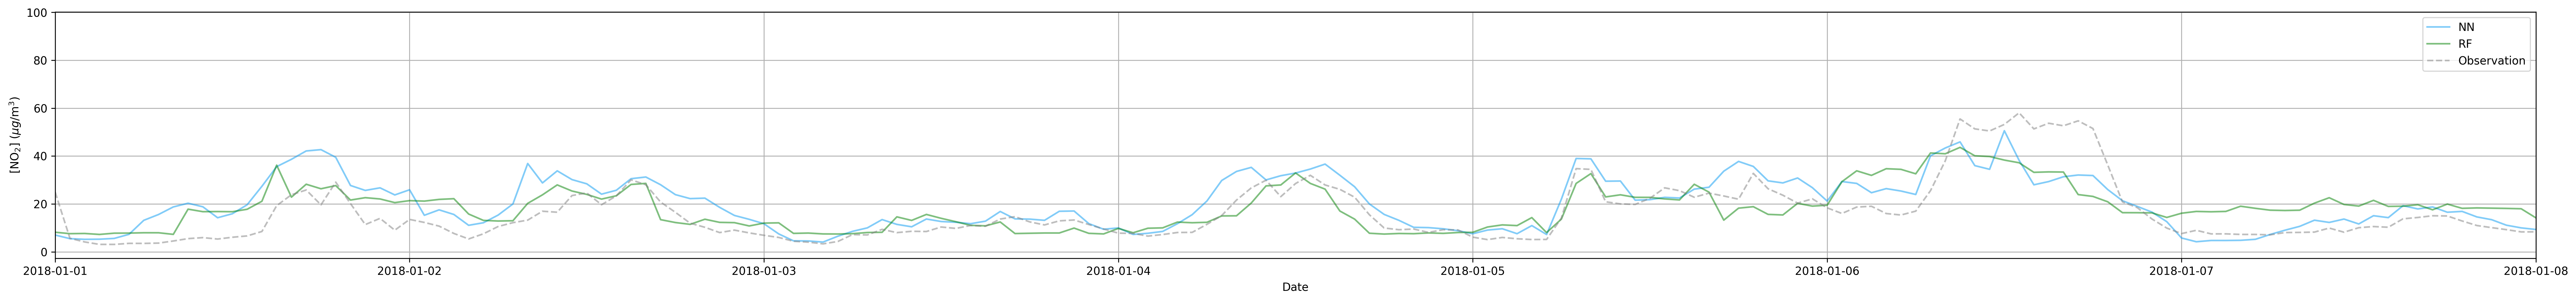

In [285]:
plot_obj.plot_long_timeseries(all=False, start_month=1, start_day=1, n_months=0, n_days=7)

In [287]:
plot_obj.get_stats(RF=False)
plot_obj.get_stats(RF=True);

Stats for NN
RMSE train (𝜇𝑔/𝑚3): 7.28
RMSE test (𝜇𝑔/𝑚3): 8.91
Correlation train: 0.88
Correlation test: 0.74
Explained variance train: 0.76
Explained variance test: 0.53
MAE train (𝜇𝑔/𝑚3): 5.23
MAE test (𝜇𝑔/𝑚3): 6.37
Stats for RF
RMSE train (𝜇𝑔/𝑚3): 9.38
RMSE test (𝜇𝑔/𝑚3): 10.23
Correlation train: 0.76
Correlation test: 0.64
Explained variance train: 0.57
Explained variance test: 0.41
MAE train (𝜇𝑔/𝑚3): 6.99
MAE test (𝜇𝑔/𝑚3): 7.79
